# Ronchi grating frames analysis of ADC effects

In [140]:
import matplotlib.pyplot as plt  
import pandas as pd  
import os
import numpy as np
from astropy.io import fits 

from PIL import Image


#conda install -c astropy photutils

from photutils import centroid_com, centroid_1dg, centroid_2dg

#need to install newer version of scipy from conda, need 1.2 or newer for find_peaks function

from scipy.signal import find_peaks

#for animations
from matplotlib import animation, rc
from IPython.display import HTML

#patches
from matplotlib import patches as patches


from astropy.modeling import models, fitting

#from scipy.interpolate import interp1d
from scipy.signal import savgol_filter

from astropy.modeling.models import custom_model

from scipy.optimize import curve_fit

import yaml
import csv
import datetime

In [141]:
#@custom_model
def gauss_offset(x, amplitude=1., mean=0., stddev=1., H=0.):
    
    return H + amplitude * np.exp(-(x - mean) ** 2 / (2 * stddev ** 2))

def gauss_fit(H,x, y):
    mean = sum(x * y) / sum(y)
    stddev = np.sqrt(sum(y * (x - mean) ** 2) / sum(y))
    popt, pcov = curve_fit(gauss_offset, x, y, p0=[H,max(y), mean, stddev])
    return popt

In [150]:
event_timestamp_list = [
#done    '20200114.061041'
#done    '20200114.061137'
#    '20200114.061204'
#    '20200114.061305'
#done    '20200114.061331'
#    '20200114.061424'
#    '20200114.061521'
#    '20200114.061630'
#    '20200114.061757'
#    '20200114.061905'
#    '20200114.061937'
#    '20200114.062150'
#    '20200114.062432'
#    '20200114.062528'
#    '20200114.062730'
#    '20200114.062834'
#    '20200114.062834'
#    '20200114.064427'
#    '20200114.064522'
#    '20200114.064605'
#    '20200114.064650'
#    '20200114.064901'
#    '20200114.065609'
#    '20200114.070555'
#    '20200114.070627'
#    '20200114.070728'
#    '20200114.070815'
#    '20200114.070918'
#    '20200114.070950'
#    '20200114.071100'
#    '20200114.071216'
#    '20200114.071500'
#    '20200114.071716'
#    '20200114.071902'
#    '20200114.072050'
#    '20200114.072233'
#    '20200114.072416'
#    '20200114.072529'
#    '20200114.072609'
#    '20200114.072722'
#    '20200114.072837'
#    '20200114.072947'
#    '20200114.073119'
#    '20200114.073545'
#    '20200114.073822'
#    '20200114.074017'
#    '20200114.074317'
#    '20200114.074519'
#    '20200114.074642'
#    '20200114.074713'
#    '20200114.074845'
#    '20200114.075114'
#    '20200114.075225'
#    '20200114.075325'
#    '20200114.075432'
#    '20200114.075621'
#    '20200114.075731'
#    '20200114.080222'
#    '20200114.080345'
#    '20200114.080540'
#    '20200114.080617'
#    '20200114.080715'
#    '20200114.080750'
#    '20200114.080829'
#    '20200114.080923'
]

In [151]:
event_timestamp=event_timestamp_list[0]
print(event_timestamp)

20200114.061137


In [152]:
len(event_timestamp_list)

1

In [153]:
raunche_df=pd.read_csv('raunche_inputs.csv')

In [154]:
#with open('params/raunche.yaml', 'r') as f:
#    raunche_df = pd.io.json.json_normalize(yaml.load(f, Loader=yaml.FullLoader))

In [155]:
raunche_df.set_index('timestamp',inplace=True,drop=False)

In [156]:
#raunche_params = []

In [157]:
#if event_timestamp in raunche_df.index:
#    raunche_params = raunche_df.loc[event_timestamp]
#else:
#    raunche_params = raunche_df.loc['default']

In [158]:
raunche_df.loc[event_timestamp]

timestamp                       20200114.061137
bigbox                                      250
hafbox                                       40
pixcount_cutoff                             650
goffset_stellar_centroidx                     0
goffset_stellar_centroidy                     0
goffset_hwing1                                0
goffset_hwing2                                0
goffset_vwing1                                0
goffset_vwing2                                0
h1r                                   (50, 100)
h2r                                  (250, 300)
v1r                                   (50, 100)
v2r                                  (250, 300)
polynom_h1                                    1
polynom_h2                                    1
polynom_v1                                    1
polynom_v2                                    1
airmass                                    1.25
target_name                  lam Tau - HD 25204
Name: 20200114.061137, dtype: object

In [159]:
#raunche_params

## import our fits file

In [160]:
#filename="gf-cam.20191113.210243"
#filename="gf-cam.20191217.083513"
#filename="gf-cam.20191106.205946"
#filename="gf-cam.20200114.061041"
#filename="gf-cam.20200114.061137"
#filename="gf-cam.20200114.061204"
#filename="gf-cam.20200114.061305"
#filename="gf-cam.20200114.061331"
filename="gf-cam." + raunche_df.loc[event_timestamp]['timestamp']

path = "c:/cloudstor/codestore/jupyter/adc-proc/ADC_test_14Jan2020/"

#infocus
#im = fits.open("19sep30176-9-stack-darksub.fits")
#im = fits.open("gf-cam.20191217.083513.fits")
im = fits.open(path + filename + ".fits")
imarray0=im[0].data

### peek at the image array

In [161]:
print(imarray0)

[[483 486 467 ... 477 522 494]
 [491 457 474 ... 519 589 483]
 [407 438 468 ... 452 461 534]
 ...
 [456 445 434 ... 460 504 480]
 [478 427 476 ... 431 458 547]
 [427 375 415 ... 504 543 503]]


### preview the image

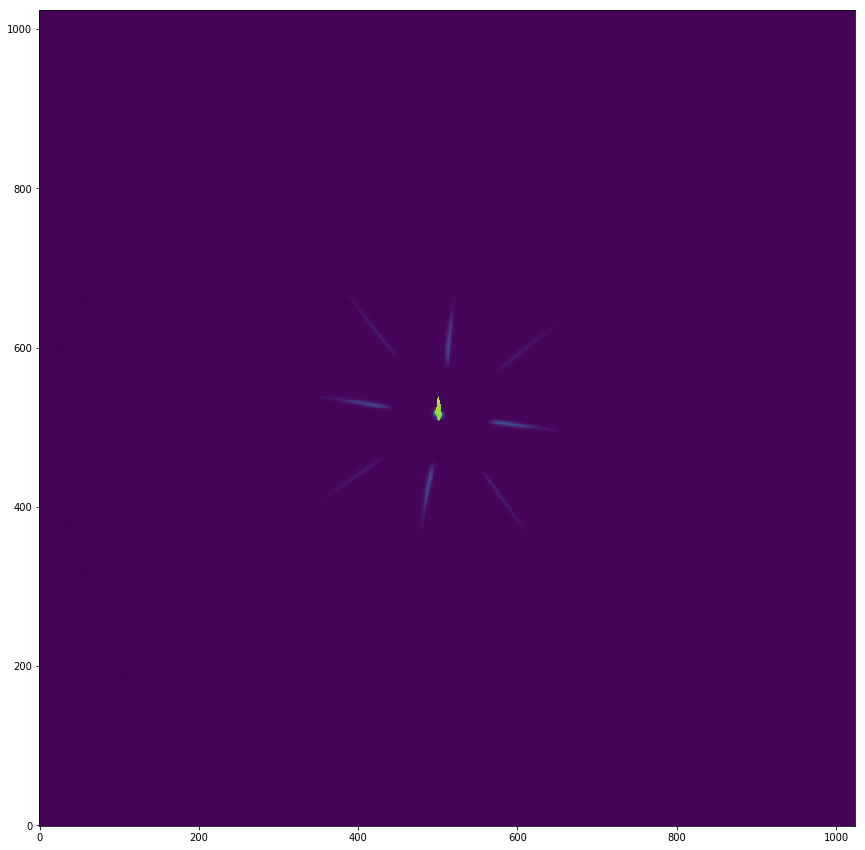

In [162]:
fig,ax = plt.subplots()

fig.set_size_inches(20, 15)
#ax.imshow(imarray,origin='lower')
ax.imshow(imarray0,origin='lower')

#rect=plt.Rectangle((0, 0), 1, 1, color='r')
# Create a Rectangle patch
#rect = patches.Rectangle(xorigin,xwidth,yheight,linewidth=1,edgecolor='r',facecolor='none')

# Add the patch to the Axes
#ax.add_patch(rect)

### Centroid the whole image
doing a 1D bin then getting the max seems to find the centroid most accurately

In [163]:
cx, cy = centroid_com(imarray0)
print((cx,cy ))   

#if it fails, use max method
csumx=imarray0.sum(axis=0)
csumy=imarray0.sum(axis=1)

cx=(np.argmax(csumx))
cy=(np.argmax(csumy))
print(cx,cy)

(515.2795730276033, 509.5986541868255)
501 528


In [164]:
hafbox=40

bigbox=250

imarray=imarray0[int(cy)-bigbox:int(cy)+bigbox,int(cx)-bigbox:int(cx)+bigbox]

cx, cy = centroid_com(imarray)

stellarbox=imarray[int(cy)-hafbox:int(cy)+hafbox,int(cx)-hafbox:int(cx)+hafbox]
#stellarbox=imarray[0:495,int(cy)-hafbox:int(cy)+hafbox]

#xmean=stellarbox.sum(axis=0)
#ymean=stellarbox.sum(axis=1)



#csx=(np.argmax(xmean))
#csy=(np.argmax(ymean))


#csx=np.argmax(stellarbox,axis=0)
#csy=np.argmax(stellarbox,axis=1)

#sx = cx-hafbox+csx
#sy = cy-hafbox+csy
#print(sx,sy)

#print(sx)
#print(sy)


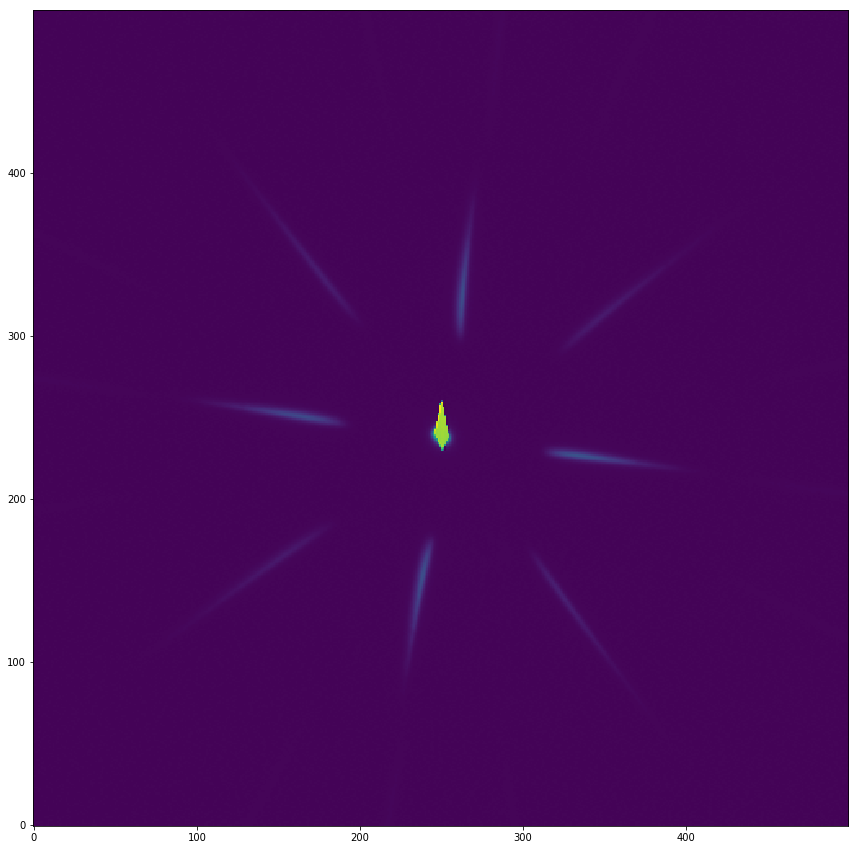

In [165]:
fig,ax = plt.subplots()

fig.set_size_inches(20, 15)
ax.imshow(imarray,origin='lower')
#ax.imshow(imarray)

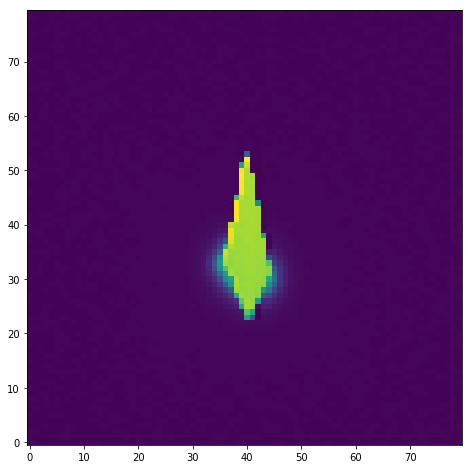

In [166]:
fig,ax = plt.subplots()

fig.set_size_inches(8, 8)
ax.imshow(stellarbox,origin='lower')

In [167]:
goffset_stellar_centroidx=raunche_df.loc[event_timestamp]['goffset_stellar_centroidx']
goffset_stellar_centroidy=raunche_df.loc[event_timestamp]['goffset_stellar_centroidy']

In [168]:
#print(xmean)

xsum=stellarbox.sum(axis=0)
ysum=stellarbox.sum(axis=1)

print('x direction')

data=xsum
y=(data-np.amin(data))/(np.amax(data)-np.amin(data))
x=np.arange(80)
H, A, x0, stddev = gauss_fit(goffset_stellar_centroidx,x, y)
print(H)
print(A)
print(x0)
print(stddev)
csx=A

print('y direction')

data=ysum
y=(data-np.amin(data))/(np.amax(data)-np.amin(data))
x=np.arange(80)
H, A, x0, stddev = gauss_fit(goffset_stellar_centroidy,x, y)
print(H)
print(A)
print(x0)
print(stddev)
csy=A

#csx=(np.argmax(xsum))
#csy=(np.argmax(ysum))

sx = cx-hafbox+csx
sy = cy-hafbox+csy

x direction
0.9618542265022635
39.88076720501164
-2.242564675868666
0.004686017241780042
y direction
0.918058057323341
34.514606675041236
7.186990541839267
0.00161655712069047


In [169]:
print(sx)
print(sy)

250.36972648057272
242.30314681375938


### plot the centroid coordinates

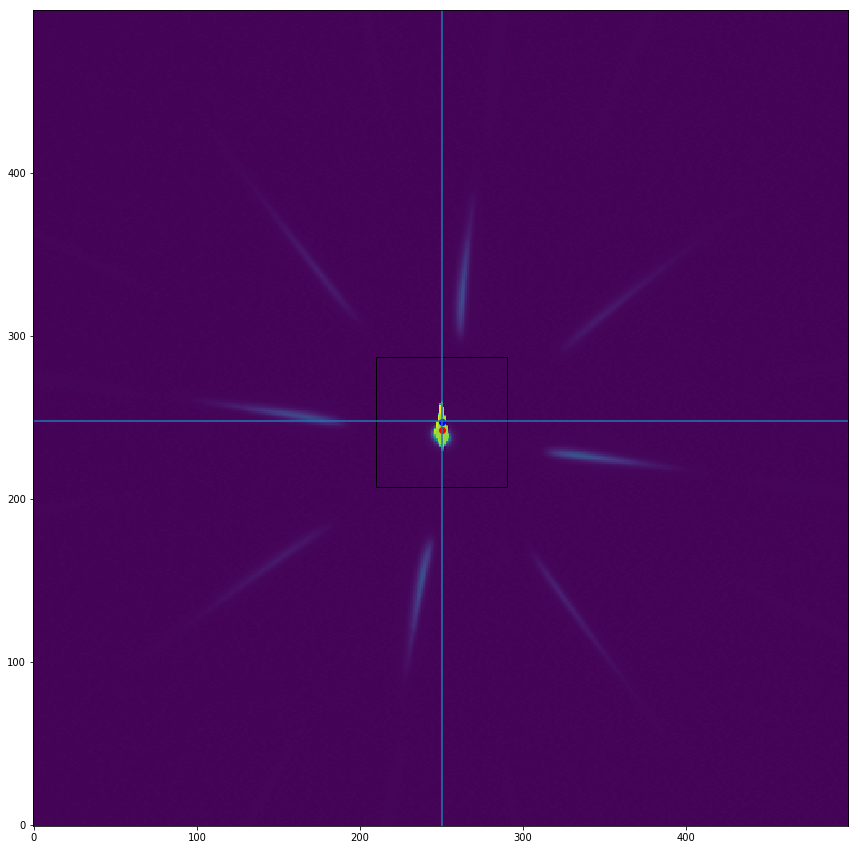

In [170]:
fig,ax = plt.subplots()

fig.set_size_inches(20, 15)
ax.imshow(imarray,origin='lower')


ax.plot(int(cx),int(cy), 'bo')

ax.plot(int(sx),int(sy), 'ro')

p = plt.Rectangle((int(cx)-hafbox, int(cy)-hafbox), 2*hafbox, 2*hafbox, fill=False)
#p = plt.Rectangle((200, 100), 2*hafbox, 2*hafbox, fill=False)
#p.set_transform(ax.transAxes)
#p.set_clip_on(False)
ax.add_patch(p)

#ax.plot(200,100,'bo')
ax.axvline(cx)
ax.axhline(cy)




### plot a 120x400 crop of the image

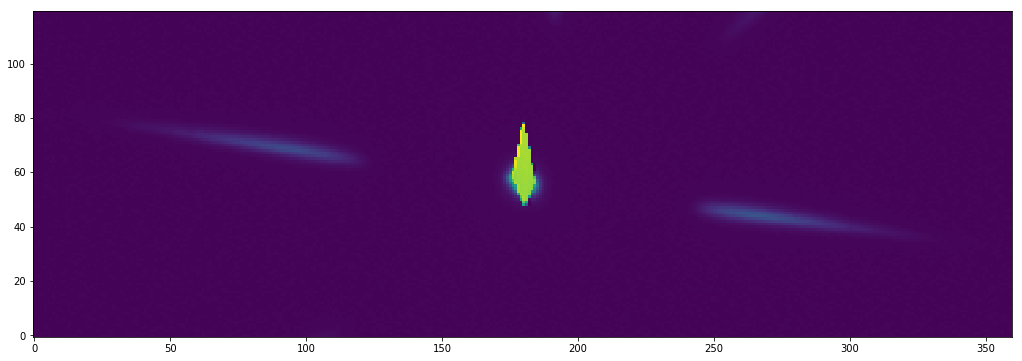

In [171]:
bds=60
bdl=180

subim=imarray[int(sy)-bds:int(sy)+bds,int(sx)-bdl:int(sx)+bdl]

fig,ax = plt.subplots()

fig.set_size_inches(18, 6)
#ax.imshow(subim,origin='lower',cmap='gray')

ax.imshow(subim,origin='lower')

#ax.plot(int(cy),int(cx), 'bo')

In [172]:
print(int(sy)-bds)
print(int(sy)+bds)
print(int(sx)-bdl)
print(int(sx)+bdl)

182
302
70
430


### populate an array max intensity values of each column

In [173]:
hormax=np.amax(subim,axis=0)

print(hormax)


[  549   541   557   563   544   579   573   582   554   550   570   573
   554   562   607   597   641   631   654   641   728   763   753   774
   818   921   906   913   971   999  1053  1105  1234  1328  1386  1499
  1589  1705  1817  1789  1871  1943  2028  2112  2158  2166  2233  2480
  2534  2628  2673  2998  3100  3222  3310  3439  3544  3516  3561  3727
  4024  4344  4520  4818  4975  5222  5223  5469  5645  5937  6049  6370
  6595  6660  6722  6924  7266  7494  7587  7605  7929  7929  8442  8475
  8933  8740  8890  8746  8821  9181  9473  9439  9420  9514  9309  9426
  9772  9729  9464  9270  8928  8886  8730  8424  8183  8052  7497  7538
  7296  6791  6314  6039  5450  5193  4828  4411  3998  3590  2940  2577
  2197  1810  1495  1128   877   745   674   599   603   558   567   574
   560   557   568   531   553   548   559   579   565   544   577   571
   566   556   578   554   561   562   569   561   577   562   565   578
   555   585   584   594   583   584   615   602   

### populate an array with the index of the column pixel intensity max

In [174]:
horargmax=np.argmax(subim,axis=0)

horargmax=horargmax.astype(float)

print(horargmax)

[ 14.  38.  95.  81.  80.  83.  88. 119.  92.   5.  79.  83.  81.  81.
  80.  80.  80.  80.  81.  81.  80.  80.  79.  79.  79.  79.  79.  78.
  78.  78.  79.  78.  77.  78.  78.  78.  77.  77.  77.  77.  77.  77.
  76.  76.  76.  76.  76.  76.  75.  75.  75.  75.  75.  75.  75.  74.
  74.  74.  74.  74.  74.  74.  73.  73.  73.  73.  73.  73.  73.  72.
  72.  72.  72.  72.  72.  71.  71.  71.  71.  71.  71.  70.  70.  70.
  70.  70.  70.  70.  69.  69.  69.  69.  69.  69.  69.  68.  68.  68.
  68.  68.  68.  67.  67.  67.  67.  67.  66.  66.  66.  66.  66.  66.
  66.  65.  65.  65.  65.  65.  65.  64.  64.  64.  64.  64.  64.  64.
  63.  66.  60.  60.  70.  70.  22. 118.  31.  27.  95.  23.  44.  70.
  90.  35.  60.  78.  22.  30.  70.  88.  80.  98.  84.  83.  85.  31.
  73.  70.  74.  59.  29.  54.  31.  59.  59.  57.  62.  54.  54.  58.
  58.  57.  58.  58.  58.  58.  58.  58.  60.  64.  67.  74.  77.  73.
  66.  61.  57.  55.  56.  55.  56. 119. 119. 119. 119. 119. 119. 119.
 118. 

In [175]:
cols=2*bdl
rows=2*bds

In [176]:
X = np.arange(cols)

In [177]:
pixcount_cutoff=raunche_df.loc[event_timestamp]['pixcount_cutoff']

### NaN out the columns with no data

In [178]:
hornanargmax=np.copy(horargmax)
for i in X:
    if hormax[int(i)] < pixcount_cutoff:
        hornanargmax[int(i)]=np.nan

In [179]:
print(hornanargmax)

[ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  81.  nan  80.  80.  79.  79.  79.  79.  79.  78.
  78.  78.  79.  78.  77.  78.  78.  78.  77.  77.  77.  77.  77.  77.
  76.  76.  76.  76.  76.  76.  75.  75.  75.  75.  75.  75.  75.  74.
  74.  74.  74.  74.  74.  74.  73.  73.  73.  73.  73.  73.  73.  72.
  72.  72.  72.  72.  72.  71.  71.  71.  71.  71.  71.  70.  70.  70.
  70.  70.  70.  70.  69.  69.  69.  69.  69.  69.  69.  68.  68.  68.
  68.  68.  68.  67.  67.  67.  67.  67.  66.  66.  66.  66.  66.  66.
  66.  65.  65.  65.  65.  65.  65.  64.  64.  64.  64.  64.  64.  64.
  63.  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  54.  58.
  58.  57.  58.  58.  58.  58.  58.  58.  60.  64.  67.  74.  77.  73.
  66.  61.  57.  55.  56.  55.  56. 119. 119. 119. 119. 119. 119. 119.
 118. 

## Plot the intensity max position of each column

Text(0.5,0,'Pixel Column')

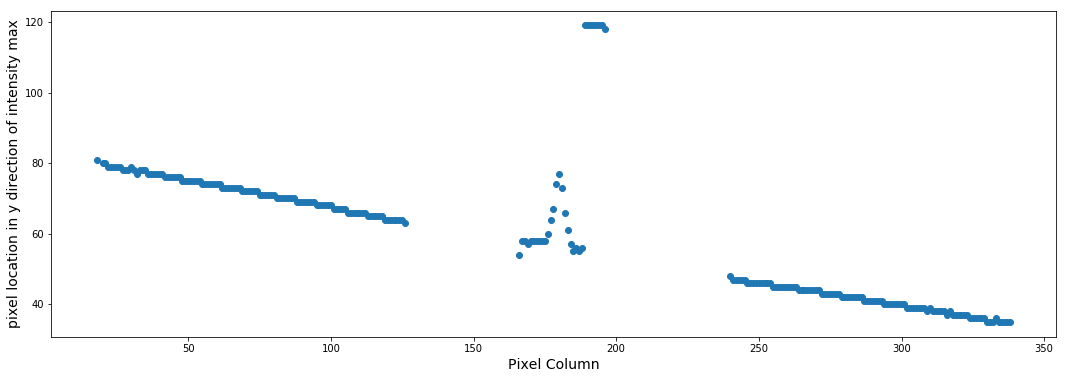

In [180]:
fig,ax = plt.subplots()

fig.set_size_inches(18, 6)

ax.scatter(X,hornanargmax)
ax.set_ylabel("pixel location in y direction of intensity max",size=14)
ax.set_xlabel("Pixel Column",size=14)
#plt.scatter(np.linspace(0,60,60),horargmax[60:120])

In [181]:
#code to see gaussian fit of one row

#data=subim[:,70]
#y=(data-np.amin(data))/(np.amax(data)-np.amin(data))
    
#x=np.arange(rows)
#plt.scatter(x,data)

In [182]:
print(raunche_df.loc[event_timestamp]['polynom_h1'])
print(raunche_df.loc[event_timestamp]['polynom_h1'])
print(raunche_df.loc[event_timestamp]['h1r'])
print(raunche_df.loc[event_timestamp]['h2r'])

1
1
(50, 100)
(250, 300)


In [183]:
polynom=1
polynom_h1=raunche_df.loc[event_timestamp]['polynom_h1']
polynom_h2=raunche_df.loc[event_timestamp]['polynom_h2']
polynom_v1=raunche_df.loc[event_timestamp]['polynom_v1']
polynom_v2=raunche_df.loc[event_timestamp]['polynom_v2']
#polynom=2

In [195]:
h1r=eval(raunche_df.loc[event_timestamp]['h1r'])
h2r=eval(raunche_df.loc[event_timestamp]['h2r'])

In [196]:

#h1r=(50,100)
#h2r=(270,330)

#h1r=(20,125)
#h2r=(250,330)



horwing1 = np.polyfit(X[h1r[0]:h1r[1]], horargmax[h1r[0]:h1r[1]], polynom)
print(horwing1)

horwing2 = np.polyfit(X[h2r[0]:h2r[1]], horargmax[h2r[0]:h2r[1]], polynom)
print(horwing2)

[-0.15198079 82.82256903]
[-0.12960384 78.5962545 ]


In [203]:
raunche_df.at[event_timestamp,'goffset_hwing1']=0.1
goffset_hwing1=raunche_df.loc[event_timestamp]['goffset_hwing1']
goffset_hwing2=raunche_df.loc[event_timestamp]['goffset_hwing2']

In [204]:
raunche_df.loc[event_timestamp]['goffset_hwing1']

0.1

In [205]:
ghorwing1 = []

X1=range(h1r[0],h1r[1],1)

for i in X1:
    whichcol = i
    data=subim[:,whichcol]
    y=(data-np.amin(data))/(np.amax(data)-np.amin(data))
    
    x=np.arange(rows)
    
    H, A, x0, stddev = gauss_fit(goffset_hwing1,x, y)
    
    ghorwing1.append(A)
    
ghorwing1=np.array(ghorwing1)

ghorwing2 = []

X2=range(h2r[0],h2r[1],1)

for i in X2:
    whichcol = i
    data=subim[:,whichcol]
    y=(data-np.amin(data))/(np.amax(data)-np.amin(data))
    
    x=np.arange(rows)
    
    H, A, x0, stddev = gauss_fit(goffset_hwing2,x, y)
    
    ghorwing2.append(A)
    
ghorwing2=np.array(ghorwing2)



In [206]:
print(ghorwing1)
#ghorwing2.shape

[75.33340063 75.1936602  75.03163778 74.83884009 74.65705413 74.47661336
 74.35043177 74.19635387 74.10688613 73.89392452 73.82022203 73.70579345
 73.50922508 73.30570813 73.18856396 72.99953797 72.89999027 72.75303844
 72.62158749 72.4112037  72.29984425 72.15962093 72.00599787 71.85121438
 71.67654948 71.54479205 71.37282711 71.22595234 71.0634176  70.9438808
 70.78699262 70.64555752 70.46781747 70.30536476 70.12948232 69.99492336
 69.84098147 69.67739716 69.53131394 69.36858326 69.21070645 69.05886115
 68.93428136 68.78692964 68.62922249 68.46041115 68.2928933  68.11873878
 67.94872533 67.80050925]


In [207]:
gaushwing1 = np.polyfit(X1, ghorwing1, polynom_h1)
gh1 = np.poly1d(gaushwing1)
gaushwing2 = np.polyfit(X2, ghorwing2, polynom_h2)
gh2 = np.poly1d(gaushwing2)

Text(0.5,1,'slope of horizontal left order from ronchi grating')

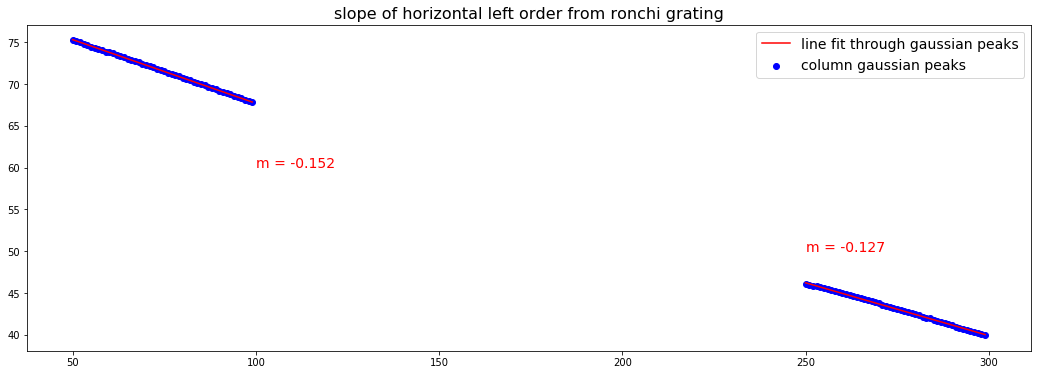

In [208]:
#m_hdiff=str(abs(round(gauswing2[0]-gauswing1[0],3)))

fig,ax = plt.subplots()

fig.set_size_inches(18, 6)

ax.scatter(X1,ghorwing1, label="column gaussian peaks", color = "blue")
ax.plot(X1,gh1(X1),color='red',label="line fit through gaussian peaks")
ax.scatter(X2,ghorwing2,color = "blue")
ax.plot(X2,gh2(X2),color='red',)
ax.text(100,60,'m = ' + str(round(gaushwing1[0],3)),fontsize=14,color='red')
ax.text(250,50,'m = ' + str(round(gaushwing2[0],3)),fontsize=14,color='red')
#ax.text(150,20,'diff between hor wings = ' + m_hdiff,fontsize=14,color='red')
ax.legend(fontsize=14)
ax.set_title("slope of horizontal left order from ronchi grating",fontsize=16)

## work in the vertical direction

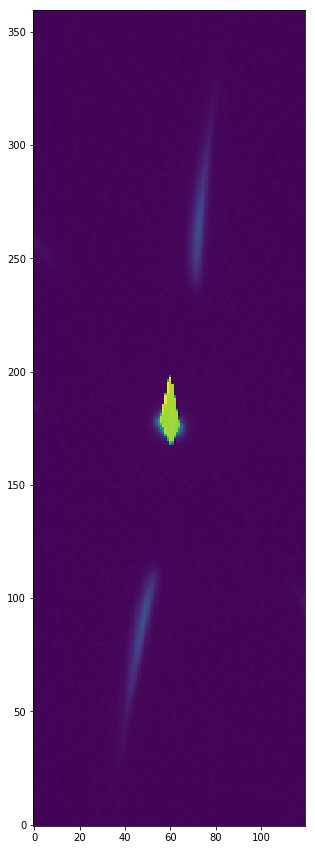

In [209]:
subvim=imarray[int(sy)-bdl:int(sy)+bdl,int(sx)-bds:int(sx)+bds]

fig,ax = plt.subplots()

fig.set_size_inches(20, 15)
#ax.imshow(subim,origin='lower',cmap='gray')

ax.imshow(subvim, origin='lower')

#ax.plot(int(cy),int(cx), 'bo')

In [210]:
vermax=np.amax(subvim,axis=1)

print(vermax)


[  548   553   554   552   593   569   563   571   567   574   571   570
   614   565   599   616   608   652   669   697   785   889   824   821
   935   847   953   911   984  1092  1244  1259  1350  1475  1590  1772
  1743  1798  1793  1934  2057  2072  2164  2282  2424  2511  2503  2601
  2848  3072  3278  3360  3350  3512  3608  3590  3714  3804  4079  4727
  5199  5298  5233  5291  5557  5800  5962  6317  6487  6828  6792  6772
  7143  7557  7963  7832  7648  8248  8752  9096  8822  8735  9028  9496
  9685  9716  9645  9577 10105 10215 10219 10228 10050 10010 10112  9735
  9623  9335  9384  9244  8820  8135  8198  8137  7547  6813  6460  6019
  5515  4930  4232  3797  3046  2425  1903  1456  1196   946   733   647
   566   565   583   562   592   581   559   590   559   560   574   570
   564   567   579   561   554   560   554   550   549   549   566   562
   582   560   556   564   576   584   562   592   585   580   603   564
   569   579   571   607   641   661   658   704   

### populate an array with the index of the column pixel intensity max

In [211]:
verargmax=np.argmax(subvim,axis=1)

verargmax=verargmax.astype(float)

print(verargmax)

[ 59.  70. 115. 105. 116.  16.  67.  42.  20.  97.  37.  37.  60.  86.
  36.  36.  35.  36.  37.  37.  36.  37.  37.  37.  37.  37.  37.  38.
  38.  38.  38.  38.  38.  38.  39.  39.  39.  39.  39.  39.  40.  40.
  40.  40.  40.  40.  40.  41.  41.  41.  41.  41.  41.  42.  42.  42.
  42.  42.  42.  43.  43.  43.  43.  43.  43.  44.  44.  44.  44.  44.
  44.  45.  45.  45.  45.  45.  46.  46.  46.  46.  46.  46.  47.  47.
  47.  47.  47.  48.  48.  48.  48.  48.  49.  49.  49.  49.  49.  50.
  50.  50.  50.  51.  51.  51.  51.  51.  52.  52.  52.  52.  53.  53.
  53.  53.  53.  53.  53.  53.  54.  53.  49.  57.  50.  61.  42.  70.
  59.  50.  33.  14. 104.   1.  52.  86.  95. 113.  94.  86.  41. 109.
  80.  43.  24.  23.  91.  65.  61.  43. 109.  38.  69.  39.  71.  70.
  85.  73.  75.  55.  58.  66.  57.  62.  64.  61.  62.  59.  61.  60.
  60.  60.  60.  60.  59.  58.  58.  58.  57.  60.  56.  56.  56.  57.
  57.  57.  57.  57.  58.  58.  58.  58.  59.  59.  59.  59.  59.  59.
  60. 

### NaN out the columns with no data

In [212]:
vernanargmax=np.copy(verargmax)
for i in X:
    if vermax[int(i)] < pixcount_cutoff:
        vernanargmax[int(i)]=np.nan

In [213]:
print(vernanargmax)

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan 36.
 37. 37. 36. 37. 37. 37. 37. 37. 37. 38. 38. 38. 38. 38. 38. 38. 39. 39.
 39. 39. 39. 39. 40. 40. 40. 40. 40. 40. 40. 41. 41. 41. 41. 41. 41. 42.
 42. 42. 42. 42. 42. 43. 43. 43. 43. 43. 43. 44. 44. 44. 44. 44. 44. 45.
 45. 45. 45. 45. 46. 46. 46. 46. 46. 46. 47. 47. 47. 47. 47. 48. 48. 48.
 48. 48. 49. 49. 49. 49. 49. 50. 50. 50. 50. 51. 51. 51. 51. 51. 52. 52.
 52. 52. 53. 53. 53. 53. 53. 53. 53. 53. 54. nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan 62.
 64. 61. 62. 59. 61. 60. 60. 60. 60. 60. 59. 58. 58. 58. 57. 60. 56. 56.
 56. 57. 57. 57. 57. 57. 58. 58. 58. 58. 59. 59. 59. 59. 59. 59. 60. 60.
 60. nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan 71. 70.
 71. 71. 71. 72. 71. 71. 72. 71. 71. 71. 71. 72. 72

## Plot the intensity max position of each row

Text(0.5,0,'Pixel Column')

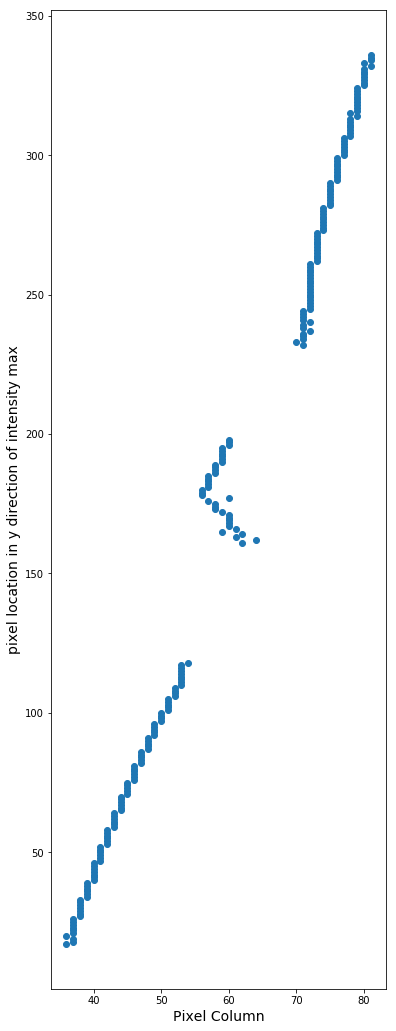

In [214]:
plt.figure(figsize=(6,18))
plt.scatter(vernanargmax,X)
plt.ylabel("pixel location in y direction of intensity max",size=14)
plt.xlabel("Pixel Column",size=14)
#plt.scatter(np.linspace(0,60,60),horargmax[60:120])



In [215]:
raunche_df.at[event_timestamp,'v1r']='(20,110)'
raunche_df.at[event_timestamp,'v2r']='(235,330)'
v1r=eval(raunche_df.loc[event_timestamp]['v1r'])
v2r=eval(raunche_df.loc[event_timestamp]['v2r'])


In [216]:
print(v1r)
print(v2r)

(20, 110)
(235, 330)


In [217]:
#v1r=(60,140)
#v1r=(30,90)
#v2r=(250,300)

#polynom=1


verwing1 = np.polyfit(X[v1r[0]:v1r[1]], verargmax[v1r[0]:v1r[1]], polynom)
print(verwing1)

verwing2 = np.polyfit(X[v2r[0]:v2r[1]], verargmax[v2r[0]:v2r[1]], polynom)
print(verwing2)

[ 0.17508334 32.50712434]
[ 0.10058791 46.55      ]


In [218]:
Y1=range(v1r[0],v1r[1],1)
print(Y1)

range(20, 110)


In [220]:
#raunche_df.at[event_timestamp,'goffset_vwing2']=0.2
goffset_vwing1=raunche_df.loc[event_timestamp]['goffset_vwing1']
goffset_vwing2=raunche_df.loc[event_timestamp]['goffset_vwing2']

In [221]:
gverwing1 = []

Y1=range(v1r[0],v1r[1],1)

for i in Y1:
    whichcol = i
    data=subvim[whichcol,:]
    y=(data-np.amin(data))/(np.amax(data)-np.amin(data))
    
    x=np.arange(rows)
    
    H, A, x0, stddev = gauss_fit(goffset_vwing1,x, y)
    
    gverwing1.append(A)
    
gverwing1=np.array(gverwing1)

gverwing2 = []

Y2=range(v2r[0],v2r[1],1)

for i in Y2:
    whichcol = i
    data=subvim[whichcol,:]
    y=(data-np.amin(data))/(np.amax(data)-np.amin(data))
    
    x=np.arange(rows)
    
    H, A, x0, stddev = gauss_fit(goffset_vwing2,x, y)
    
    gverwing2.append(A)
    
gverwing2=np.array(gverwing2)



In [222]:
print(gverwing1)
#ghorwing2.shape

[36.35307221 36.54010652 36.75323061 36.56409271 36.90093997 36.86157777
 37.28099748 37.43242377 37.28950364 37.7851277  37.90452995 37.86293007
 38.05862741 38.16982559 38.29003437 38.51397287 38.62764582 38.77574921
 38.98592252 39.14265669 39.27589375 39.4516891  39.591041   39.73534932
 39.96994074 40.07512023 40.23333183 40.40794    40.6103157  40.78985277
 40.92707874 41.03140389 41.21936726 41.37354025 41.47542229 41.56832552
 41.86720653 42.06685072 42.23134516 42.39731013 42.49959681 42.63121385
 42.83537863 43.02004939 43.18025493 43.3349941  43.4507784  43.65071054
 43.8595665  44.00064822 44.1578797  44.30929185 44.51573848 44.68897281
 44.86900729 45.02047249 45.21530537 45.4034151  45.6025245  45.76762545
 45.90897198 46.10264769 46.3211911  46.50681727 46.66740797 46.85420186
 47.06157953 47.25670582 47.44880902 47.66706983 47.85009479 48.04054028
 48.24818707 48.4421745  48.61791785 48.86287967 49.06691344 49.29695277
 49.49751478 49.71720391 49.95742069 50.17850492 50

In [223]:
raunche_df.at[event_timestamp,'polynom_v1']=2
raunche_df.at[event_timestamp,'polynom_v2']=2
polynom_v1=raunche_df.loc[event_timestamp]['polynom_v1']
polynom_v2=raunche_df.loc[event_timestamp]['polynom_v2']

In [224]:
gausvwing1 = np.polyfit(Y1, gverwing1, polynom_v1)
gv1 = np.poly1d(gausvwing1)
gausvwing2 = np.polyfit(Y2, gverwing2, polynom_v2)
gv2 = np.poly1d(gausvwing2)

Text(0.5,1,'slope of horizontal left order from ronchi grating')

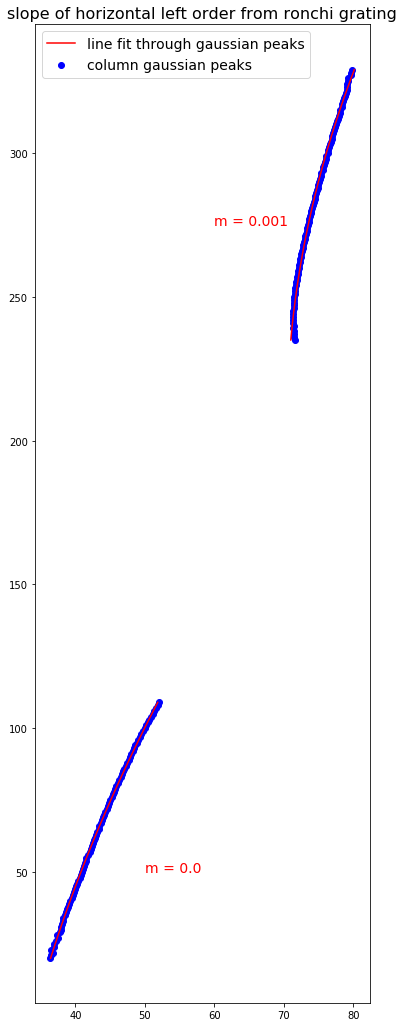

In [225]:
m_hdiff=str(abs(round(gausvwing2[0]-gausvwing1[0],3)))

fig,ax = plt.subplots()

fig.set_size_inches(6, 18)

ax.scatter(gverwing1, Y1, label="column gaussian peaks", color = "blue")
ax.plot(gv1(Y1),Y1,color='red',label="line fit through gaussian peaks")
ax.scatter(gverwing2, Y2, color = "blue")
ax.plot(gv2(Y2),Y2,color='red')
ax.text(50,50,'m = ' + str(round(gausvwing1[0],3)),fontsize=14,color='red')
ax.text(60,275,'m = ' + str(round(gausvwing2[0],3)),fontsize=14,color='red')
#ax.text(150,20,'diff between hor wings = ' + m_hdiff,fontsize=14,color='red')
ax.legend(fontsize=14)
ax.set_title("slope of horizontal left order from ronchi grating",fontsize=16) 


### Increase contrast

In [226]:
imarray3=np.cbrt(imarray)/(np.max(imarray))

### Solver

In [227]:
#Ah = np.array([[ -gaushwing1[0],1], [-gaushwing2[0],1] ])
#bh = np.array([gaushwing1[1],gaushwing2[1]])
#zh = np.linalg.solve(Ah,bh)
#print(zh)

#Av = np.array([[1, -gausvwing1[0]], [1,-gausvwing2[0]] ])
#bv = np.array([gausvwing1[1],gausvwing2[1]])
#zv = np.linalg.solve(Av,bv)
#print(zv)

#horsecx=zh[0]+int(sx)-bdl
#horsecy=zh[1]+int(sy)-bds

#versecx=zv[0]+int(sx)-bds
#versecy=zv[1]+int(sy)-bdl

In [228]:
#print(horsecx)
#print(horsecy)

#print(versecx)
#print(versecy)

In [229]:
hdr=im[0].header
#im[0].header
#hdr['ADC1']

In [230]:
airmass = raunche_df.loc[event_timestamp]['airmass']
target_name = raunche_df.loc[event_timestamp]['target_name']

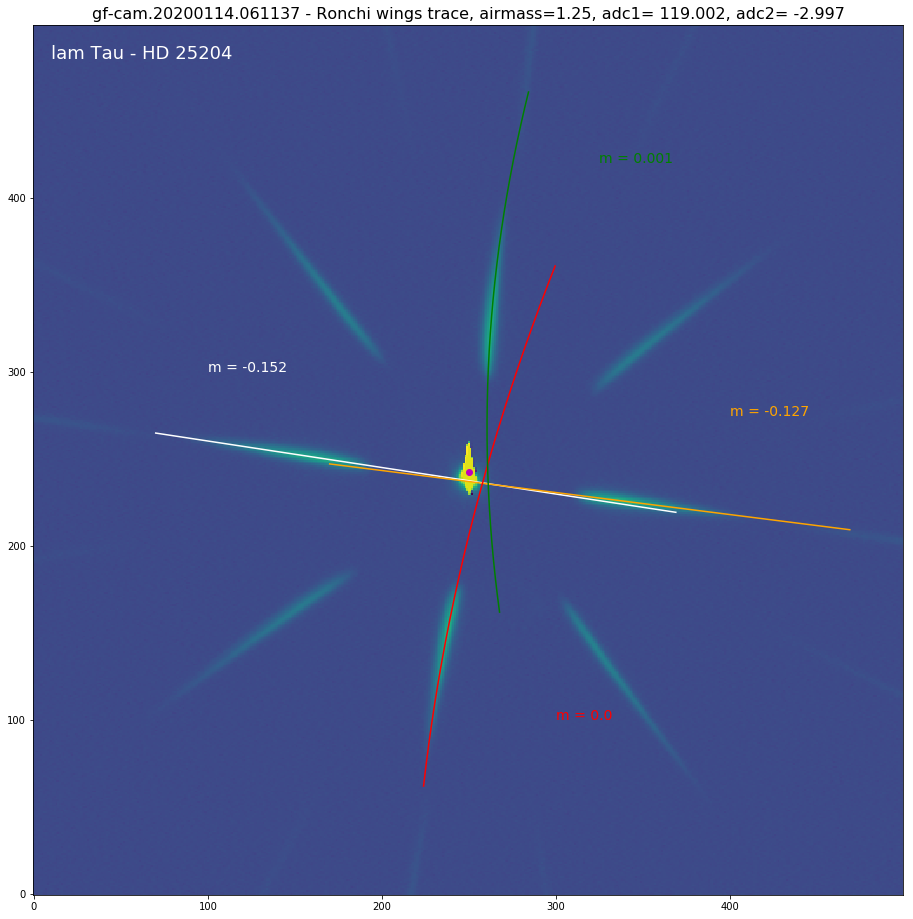

In [231]:
ff=np.arange(0,300,1)
ff2=np.arange(100,400,1)
ff3=np.arange(0,300,1)
ff4=np.arange(100,400,1)

fig,ax = plt.subplots()

fig.set_size_inches(16, 16)
ax.imshow(imarray3,origin='lower')
#ax.imshow(imarray)

ax.plot(ff+int(sx)-bdl,gh1(ff)+int(sy)-bds,color='white')
ax.text(100,300,'m = ' + str(round(gaushwing1[0],3)),fontsize=14,color='white')
ax.plot(ff2+int(sx)-bdl,gh2(ff2)+int(sy)-bds,color='orange')
ax.text(400,275,'m = ' + str(round(gaushwing2[0],3)),fontsize=14,color='orange')
ax.plot(gv1(ff3)+int(sx)-bds,ff3+int(sy)-bdl,color='red')
ax.text(300,100,'m = ' + str(round(gausvwing1[0],3)),fontsize=14,color='red')
ax.plot(gv2(ff4)+int(sx)-bds,ff4+int(sy)-bdl,color='green')
ax.text(325,420,'m = ' + str(round(gausvwing2[0],3)),fontsize=14,color='green')
ax.set_title(filename + " - Ronchi wings trace, airmass=" + airmass + ", adc1= " 
             + hdr['ADC1'] + ", adc2= " + hdr['ADC2'] ,fontsize=16)
ax.plot(sx,sy,'mo')
ax.text(10,480,target_name,fontsize=18,color='white')

#if 0 < horsecx < 500 and 0 < horsecy < 500:
#    ax.plot(horsecx,horsecy,'cD')
#if 0 < versecx < 500 and 0 < versecx < 500:
#    ax.plot(versecx,versecy,'kD')


fig.savefig(filename + 'ronchi-wing-trace.png')

In [232]:
last_processed = datetime.datetime.now()


fields=[event_timestamp,round(sx,2),round(sy,2),round(gaushwing1[0],3),
        round(gaushwing2[0],3),round(gausvwing1[0],3),round(gausvwing2[0],3),
        #round(horsecx,2),round(horsecy,2),round(versecx,2),round(versecy,2),
        hdr['ADC1'],hdr['ADC2'],airmass,target_name,last_processed]
with open(r'raunche_single.csv', 'a',newline='\n') as f:
    writer = csv.writer(f)
    writer.writerow(fields)

In [233]:
#with open(r'raunche.yaml', 'w') as file:
#    documents = yaml.dump(raunche_df, file)

### dump out the input parameters to another csv file

In [234]:
raunche_df=raunche_df.drop(columns='timestamp')
raunche_df.to_csv('raunche_inputs.csv')